<a href="https://colab.research.google.com/github/animeshchandra-121/Visual-Data-Project/blob/main/Visual_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

In [10]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from ultralytics import YOLO
import json
import time
from pathlib import Path
from datetime import datetime

# -----------------------------
# Helper: compute angle between 3 points (in degrees)
# -----------------------------
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

# -----------------------------
# Exercise Config: Squats
# -----------------------------
SQUAT_CONFIG = {
    "down_angle_range": (60, 100),
    "up_angle_range": (170, 180),
    "min_confidence": 0.4,
}

def get_person_keypoints(result):
    """Get keypoints for the most confident person"""
    if result.keypoints is None or len(result.keypoints) == 0:
        return None

    boxes = result.boxes
    if boxes is None or len(boxes) == 0:
        return None

    max_idx = int(boxes.conf.argmax())
    kpts = result.keypoints.xy[max_idx].cpu().numpy()
    return kpts

def draw_text(img, text, pos, scale=0.7, thickness=2, color=(0, 255, 0)):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness, cv2.LINE_AA)

def process_single_video(video_path, model, video_index):
    """Process a single video and return analytics data"""

    if not Path(video_path).exists():
        print(f"  ✗ Error: Video file '{video_path}' not found.")
        return None

    print(f"\n  Processing: {Path(video_path).name}")

    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    output_filename = f"squat_output_{video_index}.mp4"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (960, 540))

    # Analytics data collection
    analytics_data = {
        'video_path': str(video_path),
        'video_name': Path(video_path).name,
        'processed_at': datetime.now().isoformat(),
        'frame_numbers': [],
        'angles': [],
        'left_knee_angles': [],
        'right_knee_angles': [],
        'rep_completion_times': [],
        'fps': fps,
        'total_frames': total_frames,
        'width': width,
        'height': height,
    }

    rep_count = 0
    phase = "up"
    rep_start_time = time.time()
    start_time = time.time()
    frame_count = 0

    print(f"  Frames: {total_frames} | FPS: {fps}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        current_time = time.time() - start_time

        if frame_count % max(1, total_frames // 10) == 0:
            print(f"    Progress: {frame_count}/{total_frames}", end='\r')

        frame = cv2.resize(frame, (960, 540))
        results = model(frame, verbose=False)
        result = results[0]

        kpts = get_person_keypoints(result)
        feedback_text = "No person detected"
        squat_angle = None
        left_knee_angle = None
        right_knee_angle = None

        if kpts is not None:
            left_hip = kpts[11]
            left_knee = kpts[13]
            left_ankle = kpts[15]
            right_hip = kpts[12]
            right_knee = kpts[14]
            right_ankle = kpts[16]

            left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
            squat_angle = (left_knee_angle + right_knee_angle) / 2.0

            # Record analytics
            analytics_data['frame_numbers'].append(frame_count)
            analytics_data['angles'].append(float(squat_angle))
            analytics_data['left_knee_angles'].append(float(left_knee_angle))
            analytics_data['right_knee_angles'].append(float(right_knee_angle))

            down_low, down_high = SQUAT_CONFIG["down_angle_range"]
            up_low, up_high = SQUAT_CONFIG["up_angle_range"]

            if squat_angle is not None:
                if phase == "up":
                    if down_low <= squat_angle <= down_high:
                        phase = "down"
                elif phase == "down":
                    if up_low <= squat_angle <= up_high:
                        phase = "up"
                        rep_count += 1
                        rep_duration = time.time() - rep_start_time
                        analytics_data['rep_completion_times'].append(float(rep_duration))
                        rep_start_time = time.time()

                if squat_angle < down_low:
                    feedback_text = "Too deep! Control the squat."
                elif down_low <= squat_angle <= down_high:
                    feedback_text = "Good depth!"
                elif down_high < squat_angle < up_low:
                    feedback_text = "In between – go deeper or stand up."
                elif up_low <= squat_angle <= up_high:
                    feedback_text = "Standing straight."
                else:
                    feedback_text = "Locking knees – soften the top."

            for point in [left_hip, left_knee, left_ankle, right_hip, right_knee, right_ankle]:
                x, y = int(point[0]), int(point[1])
                cv2.circle(frame, (x, y), 5, (0, 255, 255), -1)

            if squat_angle is not None:
                lkx, lky = int(left_knee[0]), int(left_knee[1])
                rkx, rky = int(right_knee[0]), int(right_knee[1])
                draw_text(frame, f"L: {int(left_knee_angle)}", (lkx - 40, lky - 10), scale=0.5)
                draw_text(frame, f"R: {int(right_knee_angle)}", (rkx - 40, rky - 10), scale=0.5)

        draw_text(frame, "Exercise: Squats", (20, 30), scale=0.8)
        draw_text(frame, f"Reps: {rep_count}", (20, 70), scale=0.8)
        draw_text(frame, f"Phase: {phase}", (20, 110), scale=0.8)
        draw_text(frame, f"Time: {current_time:.1f}s", (20, 150), scale=0.8)

        if squat_angle is not None:
            draw_text(frame, f"Angle: {int(squat_angle)}", (300, 70), scale=0.8)

        draw_text(frame, feedback_text, (20, 500), scale=0.6, color=(0, 0, 255))

        out.write(frame)

        # key = cv2.waitKey(1) & 0xFF
        # if key == ord('q'):
        #     break

    cap.release()
    out.release()

    print(f"\n  ✓ Processed successfully")
    print(f"    - Reps counted: {rep_count}")
    print(f"    - Output video: {output_filename}")

    # Calculate summary stats
    analytics_data['total_reps'] = rep_count
    analytics_data['total_duration'] = sum(analytics_data['rep_completion_times']) if analytics_data['rep_completion_times'] else 0

    return analytics_data

def get_video_paths():
    """Get multiple video paths from user"""
    video_paths = []

    print("\n" + "="*70)
    print("Enter video file paths (one per line)")
    print("Press Enter twice when done")
    print("="*70)

    while True:
        path = input(f"Video {len(video_paths) + 1}: ").strip()

        if path == "":
            if len(video_paths) > 0:
                break
            else:
                print("Please enter at least one video path.")
                continue

        if Path(path).exists():
            video_paths.append(path)
            print(f"  ✓ Added: {Path(path).name}")
        else:
            print(f"  ✗ File not found: {path}")

    return video_paths

def main():
    print("\n" + "="*70)
    print("SQUAT EXERCISE ANALYZER - VERSION 1: MULTI-VIDEO PROCESSING")
    print("="*70)

    model_path = "yolov8s-pose.pt"
    print("\nLoading YOLO Pose model...")
    model = YOLO(model_path)
    print("✓ Model loaded\n")

    # Get video paths
    video_paths = get_video_paths()

    if not video_paths:
        print("\nNo videos to process. Exiting.")
        return

    # Process all videos
    all_analytics = []

    print(f"\n{'='*70}")
    print(f"Processing {len(video_paths)} video(s)...")
    print(f"{'='*70}")

    for idx, video_path in enumerate(video_paths, 1):
        print(f"\n[{idx}/{len(video_paths)}]")
        analytics = process_single_video(video_path, model, idx)

        if analytics is not None:
            all_analytics.append(analytics)


    # Save combined analytics data
    combined_data = {
        'total_videos_processed': len(all_analytics),
        'processed_at': datetime.now().isoformat(),
        'videos': all_analytics
    }

    analytics_path = "squat_analytics_data.json"
    with open(analytics_path, 'w') as f:
        json.dump(combined_data, f, indent=2)

    print(f"\n{'='*70}")
    print("✓ PROCESSING COMPLETE")
    print(f"{'='*70}")
    print(f"\n✓ Analytics data saved to: {analytics_path}")
    print(f"  - Total videos processed: {len(all_analytics)}")
    print(f"  - Output videos: squat_output_1.mp4, squat_output_2.mp4, etc.")
    print(f"\nNext step: Run Version 2 script to generate analytics visualizations")

if __name__ == "__main__":
    main()


SQUAT EXERCISE ANALYZER - VERSION 1: MULTI-VIDEO PROCESSING

Loading YOLO Pose model...
✓ Model loaded


Enter video file paths (one per line)
Press Enter twice when done
Video 1: /content/squat_7.mp4
  ✓ Added: squat_7.mp4
Video 2: /content/squat_8.mp4
  ✓ Added: squat_8.mp4
Video 3: /content/squat_13.mp4
  ✓ Added: squat_13.mp4
Video 4: 

Processing 3 video(s)...

[1/3]

  Processing: squat_7.mp4
  Frames: 58 | FPS: 25.0
    Progress: 55/58
  ✓ Processed successfully
    - Reps counted: 1
    - Output video: squat_output_1.mp4

[2/3]

  Processing: squat_8.mp4
  Frames: 101 | FPS: 23.976023976023978
    Progress: 100/101
  ✓ Processed successfully
    - Reps counted: 1
    - Output video: squat_output_2.mp4

[3/3]

  Processing: squat_13.mp4
  Frames: 130 | FPS: 23.976023976023978
    Progress: 130/130
  ✓ Processed successfully
    - Reps counted: 2
    - Output video: squat_output_3.mp4

✓ PROCESSING COMPLETE

✓ Analytics data saved to: squat_analytics_data.json
  - Total videos p

SQUAT EXERCISE ML ANALYTICS - VERSION 2

✓ Loaded analytics for 3 video(s)
  ✓ 1. squat_7.mp4 - 1 reps
  ✓ 2. squat_8.mp4 - 1 reps
  ✓ 3. squat_13.mp4 - 2 reps

✓ 3/3 videos have valid data

Generating ML-based analytics visualizations...
✓ Analytics plot saved as 'squat_analytics_ml.png'


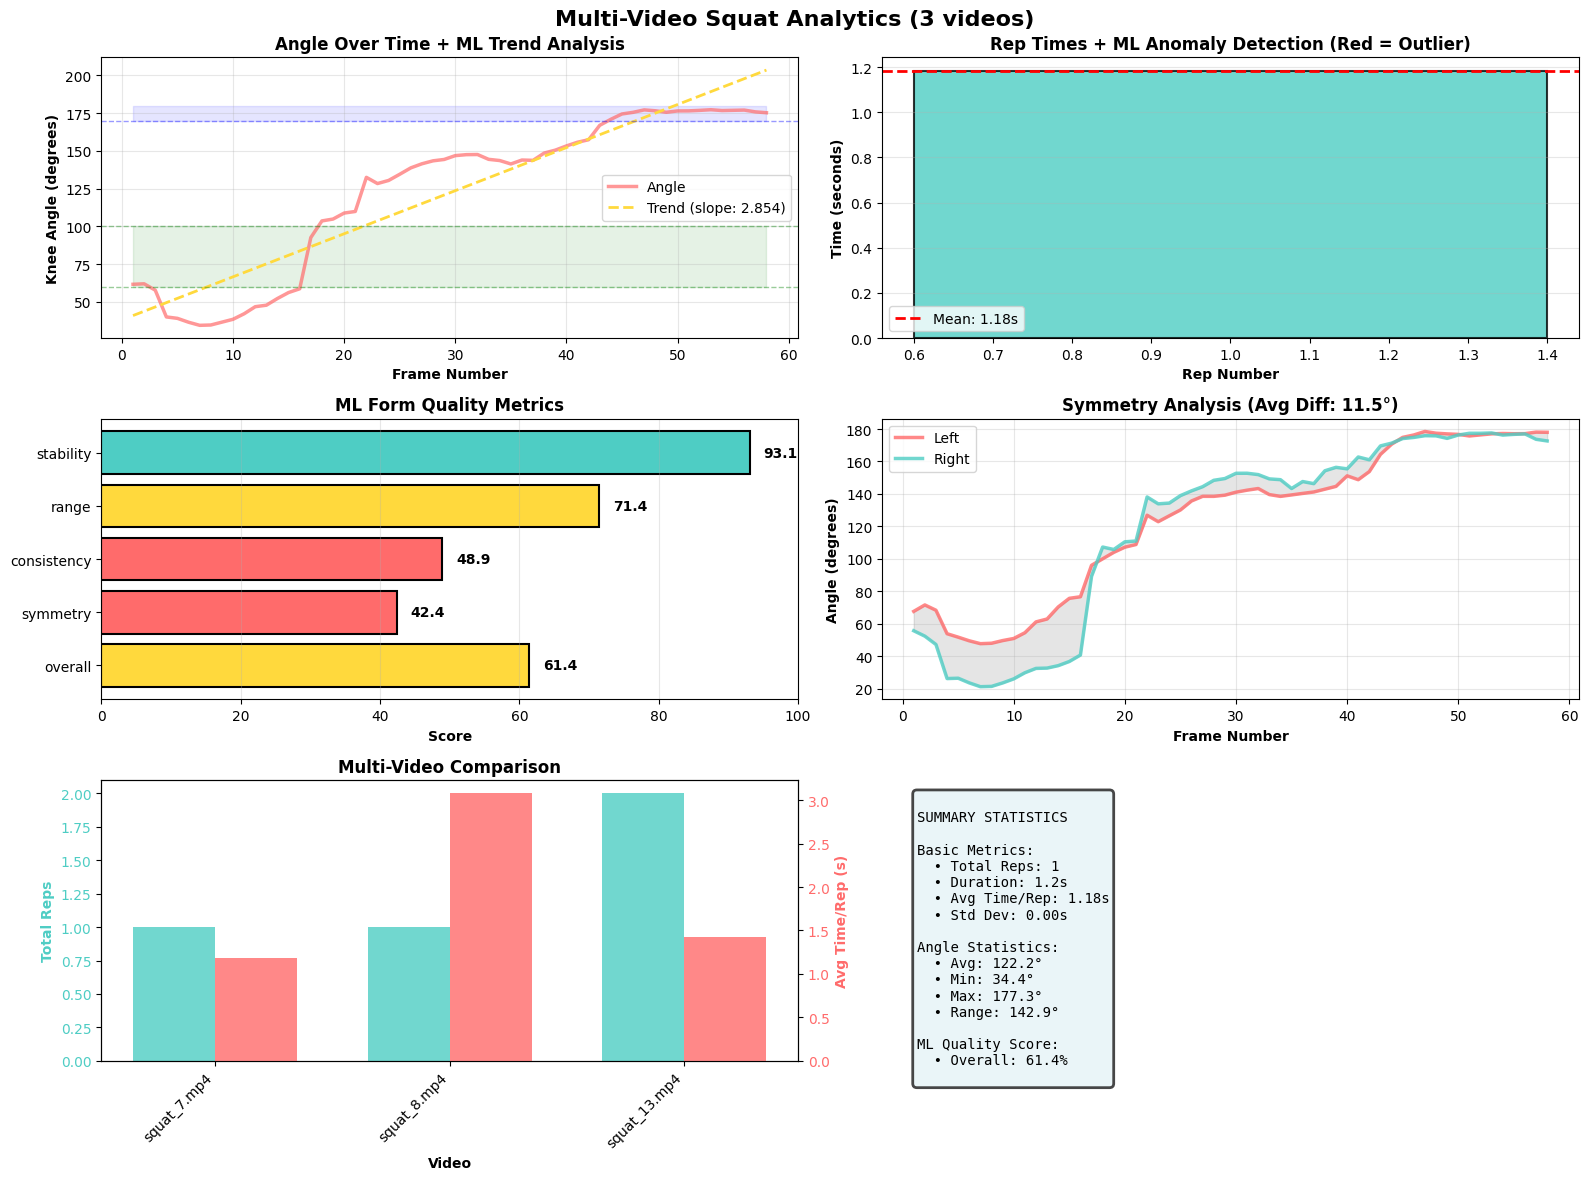


Generating ML-enhanced detailed report...
✓ ML Report saved as 'squat_analysis_ml_report.txt'

✓ ML ANALYTICS GENERATION COMPLETE

Generated files:
  1. squat_analytics_ml.png - ML visualization dashboard
  2. squat_analysis_ml_report.txt - ML-based detailed report


In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

def load_analytics_data(data_path="squat_analytics_data.json"):
    """Load analytics data from JSON file"""
    if not Path(data_path).exists():
        print(f"Error: Analytics data file '{data_path}' not found.")
        print("Please run Version 1 (processing script) first to generate this file.")
        return None

    with open(data_path, 'r') as f:
        data = json.load(f)

    return data

def ml_anomaly_detection(rep_times):
    """Detect anomalous reps using Isolation Forest"""
    if len(rep_times) < 3:
        return np.zeros(len(rep_times), dtype=int)

    X = np.array(rep_times).reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    anomalies = iso_forest.fit_predict(X_scaled)

    return anomalies

def ml_trend_analysis(angles):
    """Analyze trend in squat angles using Linear Regression"""
    if len(angles) < 10:
        return None, None

    X = np.arange(len(angles)).reshape(-1, 1)
    y = np.array(angles)

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]
    return slope, model

def ml_form_quality_score(left_angles, right_angles, angles):
    """Calculate form quality score using multiple metrics"""

    if not angles or not left_angles or not right_angles:
        return {
            'overall': 0,
            'symmetry': 0,
            'consistency': 0,
            'range': 0,
            'stability': 0
        }

    symmetry_diff = np.mean(np.abs(np.array(left_angles) - np.array(right_angles)))
    symmetry_score = max(0, 100 - symmetry_diff * 5)

    angle_std = np.std(angles)
    consistency_score = max(0, 100 - angle_std)

    angle_range = max(angles) - min(angles) if angles else 0
    range_score = min(100, angle_range * 0.5) if angle_range > 50 else max(0, angle_range)

    if len(angles) > 1:
        angle_diff = np.abs(np.diff(angles))
        avg_diff = np.mean(angle_diff)
        stability_score = max(0, 100 - avg_diff * 2)
    else:
        stability_score = 100

    overall_score = (symmetry_score * 0.3 + consistency_score * 0.25 +
                    range_score * 0.25 + stability_score * 0.2)

    return {
        'overall': overall_score,
        'symmetry': symmetry_score,
        'consistency': consistency_score,
        'range': range_score,
        'stability': stability_score
    }

def ml_performance_prediction(rep_times):
    """Predict performance level based on rep times"""
    if not rep_times or len(rep_times) == 0:
        return "Insufficient data"

    avg_time = np.mean(rep_times)
    consistency = np.std(rep_times) if len(rep_times) > 1 else 0

    if avg_time < 2 and consistency < 0.5:
        return "High Speed, Excellent Consistency"
    elif avg_time < 2.5 and consistency < 1:
        return "Good Speed, Good Consistency"
    elif avg_time < 3.5 and consistency < 1.5:
        return "Controlled Pace, Moderate Consistency"
    elif consistency < 2:
        return "Steady Pace, Variable Timing"
    else:
        return "Inconsistent Pace"

def plot_analytics(all_data):
    """Generate comprehensive analytics plots with ML insights"""

    valid_videos = [v for v in all_data if v['angles'] and len(v['angles']) > 0]

    if not valid_videos:
        print("Error: No valid video data found (all videos have 0 reps or no angle data)")
        return

    num_videos = len(all_data)
    data = valid_videos[0]

    if num_videos == 1:
        fig, axes = plt.subplots(3, 2, figsize=(16, 14))
        fig.suptitle(f"Squat Exercise Analytics - {data['video_name']}",
                     fontsize=16, fontweight='bold')
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle(f"Multi-Video Squat Analytics ({num_videos} videos)",
                     fontsize=16, fontweight='bold')
        axes = axes.flatten()

    ax = axes[0]
    if data['angles']:
        ax.plot(data['frame_numbers'], data['angles'], linewidth=2.5, color='#FF6B6B',
                label='Angle', alpha=0.7)

        slope, model = ml_trend_analysis(data['angles'])
        if slope is not None:
            trend_line = model.predict(np.arange(len(data['angles'])).reshape(-1, 1))
            ax.plot(data['frame_numbers'], trend_line, linewidth=2, color='#FFD93D',
                    linestyle='--', label=f'Trend (slope: {slope:.3f})')

        ax.axhline(y=60, color='green', linestyle='--', alpha=0.4, linewidth=1)
        ax.axhline(y=100, color='green', linestyle='--', alpha=0.4, linewidth=1)
        ax.axhline(y=170, color='blue', linestyle='--', alpha=0.4, linewidth=1)
        ax.fill_between(data['frame_numbers'], 60, 100, alpha=0.1, color='green')
        ax.fill_between(data['frame_numbers'], 170, 180, alpha=0.1, color='blue')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No angle data available', ha='center', va='center',
                transform=ax.transAxes, fontsize=12)

    ax.set_xlabel('Frame Number', fontweight='bold')
    ax.set_ylabel('Knee Angle (degrees)', fontweight='bold')
    ax.set_title('Angle Over Time + ML Trend Analysis', fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    rep_times = data['rep_completion_times']

    if rep_times and len(rep_times) > 0:
        anomalies = ml_anomaly_detection(rep_times)
        rep_numbers = list(range(1, len(rep_times) + 1))

        colors = ['#FF6B6B' if a == -1 else '#4ECDC4' for a in anomalies]
        ax.bar(rep_numbers, rep_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax.axhline(y=np.mean(rep_times), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(rep_times):.2f}s')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No rep data', ha='center', va='center', transform=ax.transAxes)

    ax.set_xlabel('Rep Number', fontweight='bold')
    ax.set_ylabel('Time (seconds)', fontweight='bold')
    ax.set_title('Rep Times + ML Anomaly Detection (Red = Outlier)', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    ax = axes[2]
    form_scores = ml_form_quality_score(data['left_knee_angles'],
                                        data['right_knee_angles'],
                                        data['angles'])

    metrics = list(form_scores.keys())
    scores = list(form_scores.values())
    colors_bar = ['#FF6B6B' if s < 50 else '#FFD93D' if s < 75 else '#4ECDC4' for s in scores]

    bars = ax.barh(metrics, scores, color=colors_bar, edgecolor='black', linewidth=1.5)
    ax.set_xlim(0, 100)
    ax.set_xlabel('Score', fontweight='bold')
    ax.set_title('ML Form Quality Metrics', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax.text(score + 2, i, f'{score:.1f}', va='center', fontweight='bold')

    # 4. Left vs Right symmetry
    ax = axes[3]
    if data['left_knee_angles'] and data['right_knee_angles']:
        ax.plot(data['frame_numbers'], data['left_knee_angles'],
                label='Left', linewidth=2.5, alpha=0.8, color='#FF6B6B')
        ax.plot(data['frame_numbers'], data['right_knee_angles'],
                label='Right', linewidth=2.5, alpha=0.8, color='#4ECDC4')

        symmetry_diff = np.mean(np.abs(np.array(data['left_knee_angles']) -
                                        np.array(data['right_knee_angles'])))
        ax.fill_between(data['frame_numbers'], data['left_knee_angles'],
                         data['right_knee_angles'], alpha=0.2, color='gray')
        ax.set_title(f'Symmetry Analysis (Avg Diff: {symmetry_diff:.1f}°)', fontweight='bold')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No symmetry data', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title('Symmetry Analysis', fontweight='bold')

    ax.set_xlabel('Frame Number', fontweight='bold')
    ax.set_ylabel('Angle (degrees)', fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax = axes[4]
    if num_videos > 1:
        video_names = [v['video_name'][:15] for v in all_data]
        rep_counts = [v['total_reps'] for v in all_data]
        avg_times = [np.mean(v['rep_completion_times']) if v['rep_completion_times'] else 0
                    for v in all_data]

        x = np.arange(len(video_names))
        width = 0.35

        ax2 = ax.twinx()
        bars1 = ax.bar(x - width/2, rep_counts, width, label='Reps', color='#4ECDC4', alpha=0.8)
        bars2 = ax2.bar(x + width/2, avg_times, width, label='Avg Time/Rep', color='#FF6B6B', alpha=0.8)

        ax.set_xlabel('Video', fontweight='bold')
        ax.set_ylabel('Total Reps', fontweight='bold', color='#4ECDC4')
        ax2.set_ylabel('Avg Time/Rep (s)', fontweight='bold', color='#FF6B6B')
        ax.set_xticks(x)
        ax.set_xticklabels(video_names, rotation=45, ha='right')
        ax.set_title('Multi-Video Comparison', fontweight='bold')
        ax.tick_params(axis='y', labelcolor='#4ECDC4')
        ax2.tick_params(axis='y', labelcolor='#FF6B6B')
    else:
        ax.axis('off')
        perf_pred = ml_performance_prediction(data['rep_completion_times'])
        form_scores = ml_form_quality_score(data['left_knee_angles'],
                                           data['right_knee_angles'],
                                           data['angles'])

        text = f"""
ML-BASED PERFORMANCE ANALYSIS

Performance Profile:
  {perf_pred}

Form Quality Summary:
  • Overall Score: {form_scores['overall']:.1f}/100
  • Symmetry: {form_scores['symmetry']:.1f}/100
  • Consistency: {form_scores['consistency']:.1f}/100
  • Range of Motion: {form_scores['range']:.1f}/100
  • Stability: {form_scores['stability']:.1f}/100

Recommendations:
  Use the detailed report for specific
  improvement areas based on ML analysis.
        """
        ax.text(0.1, 0.5, text, fontsize=11, verticalalignment='center',
                fontfamily='monospace', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='#FFF9E6', alpha=0.9))

    # 6. Statistics summary
    ax = axes[5]
    ax.axis('off')

    total_reps = data['total_reps']
    total_duration = data['total_duration']
    rep_times = data['rep_completion_times']
    avg_time_per_rep = np.mean(rep_times) if rep_times else 0

    form_scores = ml_form_quality_score(data['left_knee_angles'],
                                       data['right_knee_angles'],
                                       data['angles'])

    # Handle empty angles list
    if data['angles']:
        angle_avg = np.mean(data['angles'])
        angle_min = min(data['angles'])
        angle_max = max(data['angles'])
        angle_range = angle_max - angle_min
    else:
        angle_avg = angle_min = angle_max = angle_range = 0

    stats_text = f"""
SUMMARY STATISTICS

Basic Metrics:
  • Total Reps: {total_reps}
  • Duration: {total_duration:.1f}s
  • Avg Time/Rep: {avg_time_per_rep:.2f}s
  • Std Dev: {np.std(rep_times) if rep_times else 0:.2f}s

Angle Statistics:
  • Avg: {angle_avg:.1f}°
  • Min: {angle_min:.1f}°
  • Max: {angle_max:.1f}°
  • Range: {angle_range:.1f}°

ML Quality Score:
  • Overall: {form_scores['overall']:.1f}%
    """

    ax.text(0.05, 0.95, stats_text, fontsize=10, verticalalignment='top',
            fontfamily='monospace', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='#E8F4F8', alpha=0.9,
                     edgecolor='#333', linewidth=2))

    plt.tight_layout()
    plt.savefig('squat_analytics_ml.png', dpi=150, bbox_inches='tight', facecolor='white')
    print("✓ Analytics plot saved as 'squat_analytics_ml.png'")
    plt.show()

def generate_ml_report(all_data):
    """Generate ML-enhanced analysis report"""
    report_path = "squat_analysis_ml_report.txt"

    with open(report_path, 'w') as f:
        f.write("="*75 + "\n")
        f.write("SQUAT EXERCISE ML-BASED ANALYSIS REPORT\n")
        f.write("="*75 + "\n\n")

        for video_idx, data in enumerate(all_data, 1):
            f.write(f"\nVIDEO {video_idx}: {data['video_name']}\n")
            f.write("-"*75 + "\n\n")

            # Check if video has any data
            if not data['angles'] or data['total_reps'] == 0:
                f.write("⚠ WARNING: This video has insufficient data (0 reps detected)\n")
                f.write("This could be due to:\n")
                f.write("  - Poor video quality or lighting\n")
                f.write("  - Pose detection failure\n")
                f.write("  - Incorrect exercise form not matching detection criteria\n")
                f.write("  - Camera angle issues\n\n")
                f.write("Skipping detailed analysis for this video.\n")
                f.write("-"*75 + "\n\n")
                continue

            # Basic metrics
            f.write("PERFORMANCE METRICS\n")
            f.write("-"*75 + "\n")
            rep_times = data['rep_completion_times']
            f.write(f"Total Reps:                  {data['total_reps']}\n")
            f.write(f"Total Duration:              {data['total_duration']:.2f}s\n")

            if rep_times:
                f.write(f"Average Time/Rep:            {np.mean(rep_times):.2f}s\n")
                f.write(f"Fastest Rep:                 {min(rep_times):.2f}s\n")
                f.write(f"Slowest Rep:                 {max(rep_times):.2f}s\n")
                f.write(f"Time Consistency (Std Dev):  {np.std(rep_times):.2f}s\n")
            else:
                f.write("No rep timing data available.\n")
            f.write("\n")

            # ML Form Quality Scores
            f.write("ML FORM QUALITY ANALYSIS\n")
            f.write("-"*75 + "\n")
            form_scores = ml_form_quality_score(data['left_knee_angles'],
                                               data['right_knee_angles'],
                                               data['angles'])

            f.write(f"Overall Quality Score:       {form_scores['overall']:.1f}/100\n")
            f.write(f"  • Symmetry (L-R Balance):  {form_scores['symmetry']:.1f}/100 - ")
            if form_scores['symmetry'] >= 90:
                f.write("Excellent symmetry\n")
            elif form_scores['symmetry'] >= 75:
                f.write("Good symmetry\n")
            else:
                f.write("Needs improvement\n")

            f.write(f"  • Consistency:             {form_scores['consistency']:.1f}/100 - ")
            if form_scores['consistency'] >= 80:
                f.write("Very consistent\n")
            elif form_scores['consistency'] >= 60:
                f.write("Reasonably consistent\n")
            else:
                f.write("Variable angles\n")

            f.write(f"  • Range of Motion:         {form_scores['range']:.1f}/100 - ")
            if form_scores['range'] >= 75:
                f.write("Good depth\n")
            elif form_scores['range'] >= 50:
                f.write("Moderate depth\n")
            else:
                f.write("Limited depth\n")

            f.write(f"  • Stability:               {form_scores['stability']:.1f}/100 - ")
            if form_scores['stability'] >= 85:
                f.write("Very smooth\n")
            elif form_scores['stability'] >= 70:
                f.write("Smooth movement\n")
            else:
                f.write("Some jerkiness\n")
            f.write("\n")

            # Performance Profile
            f.write("PERFORMANCE PROFILE\n")
            f.write("-"*75 + "\n")
            perf_pred = ml_performance_prediction(rep_times)
            f.write(f"{perf_pred}\n\n")

            # Anomaly Detection
            f.write("ANOMALY DETECTION (ML)\n")
            f.write("-"*75 + "\n")

            if rep_times and len(rep_times) > 0:
                anomalies = ml_anomaly_detection(rep_times)
                anomaly_reps = [i+1 for i, a in enumerate(anomalies) if a == -1]

                if anomaly_reps:
                    f.write(f"Detected anomalous reps: {anomaly_reps}\n")
                    f.write("These reps had significantly different timing than others.\n")
                else:
                    f.write("No anomalous reps detected - consistent performance!\n")
            else:
                f.write("No rep data available for anomaly detection.\n")
            f.write("\n")

            # Trend Analysis
            f.write("TREND ANALYSIS (ML)\n")
            f.write("-"*75 + "\n")
            slope, _ = ml_trend_analysis(data['angles'])
            if slope is not None:
                if slope > 0.1:
                    f.write(f"Angle Trend: INCREASING (slope: {slope:.4f})\n")
                    f.write("Your form is degrading as you fatigue - maintain control!\n")
                elif slope < -0.1:
                    f.write(f"Angle Trend: DECREASING (slope: {slope:.4f})\n")
                    f.write("Your form is improving throughout - excellent!\n")
                else:
                    f.write(f"Angle Trend: STABLE (slope: {slope:.4f})\n")
                    f.write("Consistent form maintained - great control!\n")
            else:
                f.write("Insufficient data for trend analysis (need at least 10 frames).\n")
            f.write("\n")

            # Detailed recommendations
            f.write("PERSONALIZED RECOMMENDATIONS\n")
            f.write("-"*75 + "\n")

            recommendations = []

            if form_scores['symmetry'] < 70:
                recommendations.append("• Improve Left-Right Balance")
                recommendations.append("  - Practice unilateral exercises")
                recommendations.append("  - Focus on the weaker leg")

            if form_scores['consistency'] < 60:
                recommendations.append("• Increase Consistency")
                recommendations.append("  - Slow down and focus on each rep")
                recommendations.append("  - Use tempo training")

            if form_scores['range'] < 50:
                recommendations.append("• Improve Range of Motion")
                recommendations.append("  - Work on ankle and hip mobility")
                recommendations.append("  - Go deeper with controlled movement")

            if form_scores['stability'] < 70:
                recommendations.append("• Smoother Movement")
                recommendations.append("  - Reduce acceleration/deceleration")
                recommendations.append("  - Maintain constant speed")

            if rep_times and np.std(rep_times) > 1.5:
                recommendations.append("• Better Timing Consistency")
                recommendations.append("  - Practice with a metronome")
                recommendations.append("  - Maintain same pace throughout")

            if not recommendations:
                recommendations.append("✓ Excellent form! Continue current routine")
                recommendations.append("✓ Focus on progressive overload")
                recommendations.append("✓ Maintain consistency")

            for rec in recommendations:
                f.write(rec + "\n")

            f.write("\n")

        f.write("="*75 + "\n")

    print(f"✓ ML Report saved as '{report_path}'")

def main():
    print("="*75)
    print("SQUAT EXERCISE ML ANALYTICS - VERSION 2")
    print("="*75 + "\n")

    # Load analytics data
    data = load_analytics_data()
    if data is None:
        return

    videos = data['videos']
    print(f"✓ Loaded analytics for {len(videos)} video(s)")

    valid_count = sum(1 for v in videos if v['angles'] and len(v['angles']) > 0)

    for i, v in enumerate(videos, 1):
        status = "✓" if v['angles'] and len(v['angles']) > 0 else "⚠"
        print(f"  {status} {i}. {v['video_name']} - {v['total_reps']} reps")

    if valid_count == 0:
        print("\n⚠ ERROR: No valid video data found!")
        print("All videos have 0 reps or no angle data.")
        print("Please check your input videos and ensure pose detection is working correctly.")
        return

    print(f"\n✓ {valid_count}/{len(videos)} videos have valid data\n")

    # Generate visualizations and reports
    print("Generating ML-based analytics visualizations...")
    plot_analytics(videos)

    print("\nGenerating ML-enhanced detailed report...")
    generate_ml_report(videos)

    print("\n" + "="*75)
    print("✓ ML ANALYTICS GENERATION COMPLETE")
    print("="*75)
    print("\nGenerated files:")
    print("  1. squat_analytics_ml.png - ML visualization dashboard")
    print("  2. squat_analysis_ml_report.txt - ML-based detailed report")

if __name__ == "__main__":
    main()